<a href="https://colab.research.google.com/github/naemililia/masterthesis/blob/main/train_pretext_1_label.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook will be used to train the pretext task with any 1 auxiliary label


## 0. Installations and imports

In [ ]:
!pip install rasterio

In [ ]:
!pip install segmentation-models-pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 41.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_6

In [ ]:
# connect drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# create a folder for model checkpoints

%cd /home
!sudo mkdir checkpoints

/home
mkdir: cannot create directory ‘checkpoints’: File exists


In [ ]:
import rasterio
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import os
import csv
from PIL import Image
from scipy.ndimage import zoom
import torch
import random
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from matplotlib import pyplot as plt
import segmentation_models_pytorch as smp
import torchvision.models as models
import torch.nn as nn
import torchvision.transforms.functional as F
from tqdm.notebook import tqdm
from IPython.display import clear_output
from IPython.display import display

## 1. Load Senfloods data

In [ ]:
%cd /home
!sudo mkdir checkpoints

/home
mkdir: cannot create directory ‘checkpoints’: File exists


In [ ]:
# first load the raw satellite data from the S1 weakly labeled dataset of senfloods

!sudo mkdir files
!sudo mkdir files/S1weak_all

!gsutil -m rsync -r gs://sen1floods11/v1.1/data/flood_events/WeaklyLabeled/S1Weak files/S1weak_all


both the source and destination. Your crcmod installation isn't using the
module's C extension, so checksumming will run very slowly. If this is your
first rsync since updating gsutil, this rsync can take significantly longer than
usual. For help installing the extension, please see "gsutil help crcmod".

Building synchronization state...
Starting synchronization...
Copying gs://sen1floods11/v1.1/data/flood_events/WeaklyLabeled/S1Weak/Bolivia_1608856_S1Weak.tif...
Copying gs://sen1floods11/v1.1/data/flood_events/WeaklyLabeled/S1Weak/Bolivia_1037580_S1Weak.tif...
Copying gs://sen1floods11/v1.1/data/flood_events/WeaklyLabeled/S1Weak/Bolivia_1068962_S1Weak.tif...
Copying gs://sen1floods11/v1.1/data/flood_events/WeaklyLabeled/S1Weak/Bolivia_1027817_S1Weak.tif...
Copying gs://sen1floods11/v1.1/data/flood_events/WeaklyLabeled/S1Weak/Bolivia_1159714_S1Weak.tif...
Copying gs://sen1floods11/v1.1/data/flood_events/WeaklyLabeled/S1Weak/Bolivia_1041766_S1Weak.tif...
Copying gs://sen1floods11/v1.1

## 2. Define the hyperparameters

In [ ]:
AUXILIARY_DATASOURCE = 'BUILT' # 'LC', 'POP', 'BUILT'
LR = 0.001

## 3. Prepare the dataloaders

In [ ]:
# the labels are saved on my google drive
BUILT_path_senfloods = '/content/drive/MyDrive/Uni/TUB/Semester/5 - Masterarbeit/data/BUILT/Sen1floods11'
POP_path_senfloods = '/content/drive/MyDrive/Uni/TUB/Semester/5 - Masterarbeit/data/POP/Sen1floods11'
LC_path_senfloods = '/content/drive/MyDrive/Uni/TUB/Semester/5 - Masterarbeit/data/LC/Sen1floods11'


test_train_images_path = '/content/drive/MyDrive/Uni/TUB/Semester/5 - Masterarbeit/data/flood/batch_1'
test_val_images_path = '/content/drive/MyDrive/Uni/TUB/Semester/5 - Masterarbeit/data/flood/batch_2'



In [ ]:
# csv containing the train images and the corresponding label names
train_data = pd.read_csv('/content/drive/MyDrive/Uni/TUB/Semester/5 - Masterarbeit/data/S1weak_train_filenames_final.csv')
train_data

filename                               label
0     Sri-Lanka_9986038_S1Weak.tif  Sri-Lanka_9986038_S1Weak_label.npy
1      Colombia_1118446_S1Weak.tif   Colombia_1118446_S1Weak_label.npy
2     Sri-Lanka_2921607_S1Weak.tif  Sri-Lanka_2921607_S1Weak_label.npy
3       Paraguay_759808_S1Weak.tif    Paraguay_759808_S1Weak_label.npy
4      Pakistan_3726246_S1Weak.tif   Pakistan_3726246_S1Weak_label.npy
...                            ...                                 ...
3484  Sri-Lanka_9968225_S1Weak.tif  Sri-Lanka_9968225_S1Weak_label.npy
3485    Colombia_682955_S1Weak.tif    Colombia_682955_S1Weak_label.npy
3486        USA_7813429_S1Weak.tif        USA_7813429_S1Weak_label.npy
3487     Mekong_2019236_S1Weak.tif     Mekong_2019236_S1Weak_label.npy
3488     Mekong_6790806_S1Weak.tif     Mekong_6790806_S1Weak_label.npy

[3489 rows x 2 columns]

In [ ]:
# subset used to test the models without needing to load all the data
train_data_subset = pd.read_csv('/content/drive/MyDrive/Uni/TUB/Semester/5 - Masterarbeit/data/train_data_subset.csv')
train_data_subset

filename                              label
0    Paraguay_9566973_S1Weak.tif  Paraguay_9566973_S1Weak_label.npy
1       India_3385853_S1Weak.tif     India_3385853_S1Weak_label.npy
2       India_5962075_S1Weak.tif     India_5962075_S1Weak_label.npy
3         USA_2091939_S1Weak.tif       USA_2091939_S1Weak_label.npy
4         USA_9494541_S1Weak.tif       USA_9494541_S1Weak_label.npy
..                           ...                                ...
295  Pakistan_6114632_S1Weak.tif  Pakistan_6114632_S1Weak_label.npy
296       USA_1147312_S1Weak.tif       USA_1147312_S1Weak_label.npy
297  Colombia_1131006_S1Weak.tif  Colombia_1131006_S1Weak_label.npy
298  Colombia_8600107_S1Weak.tif  Colombia_8600107_S1Weak_label.npy
299       USA_1407262_S1Weak.tif       USA_1407262_S1Weak_label.npy

[300 rows x 2 columns]

In [ ]:
val_data = pd.read_csv('/content/drive/MyDrive/Uni/TUB/Semester/5 - Masterarbeit/data/S1weak_val_filenames_final.csv')
val_data

filename                               label
0         Spain_773144_S1Weak.tif       Spain_773144_S1Weak_label.npy
1     Paraguay_5454407_S1Weak.tif   Paraguay_5454407_S1Weak_label.npy
2          USA_9138222_S1Weak.tif        USA_9138222_S1Weak_label.npy
3      Somalia_9901311_S1Weak.tif    Somalia_9901311_S1Weak_label.npy
4        Ghana_5992759_S1Weak.tif      Ghana_5992759_S1Weak_label.npy
..                            ...                                 ...
867     Mekong_4744109_S1Weak.tif     Mekong_4744109_S1Weak_label.npy
868     Mekong_4486367_S1Weak.tif     Mekong_4486367_S1Weak_label.npy
869    Bolivia_3059419_S1Weak.tif    Bolivia_3059419_S1Weak_label.npy
870   Pakistan_2488056_S1Weak.tif   Pakistan_2488056_S1Weak_label.npy
871  Sri-Lanka_8254390_S1Weak.tif  Sri-Lanka_8254390_S1Weak_label.npy

[872 rows x 2 columns]

In [ ]:
val_data_subset = pd.read_csv('/content/drive/MyDrive/Uni/TUB/Semester/5 - Masterarbeit/data/val_data_subset.csv')
val_data_subset

filename                               label
0   Sri-Lanka_3153937_S1Weak.tif  Sri-Lanka_3153937_S1Weak_label.npy
1       India_7089682_S1Weak.tif      India_7089682_S1Weak_label.npy
2    Paraguay_7990252_S1Weak.tif   Paraguay_7990252_S1Weak_label.npy
3   Sri-Lanka_3675661_S1Weak.tif  Sri-Lanka_3675661_S1Weak_label.npy
4       India_8959582_S1Weak.tif      India_8959582_S1Weak_label.npy
..                           ...                                 ...
70    Colombia_565072_S1Weak.tif    Colombia_565072_S1Weak_label.npy
71      India_8862939_S1Weak.tif      India_8862939_S1Weak_label.npy
72      Mekong_288773_S1Weak.tif      Mekong_288773_S1Weak_label.npy
73    Somalia_1595869_S1Weak.tif    Somalia_1595869_S1Weak_label.npy
74     Mekong_3758022_S1Weak.tif     Mekong_3758022_S1Weak_label.npy

[75 rows x 2 columns]

In [ ]:
# functions needed for the loading of the data

def getArrFlood(fname):
    """Load .tif data into array"""
    return rasterio.open(fname).read()

def download_flood_water_data_from_list_singlelabel(l):
    """
    Download and prepare training data from file list.

    Gets training_list from load_flood_train_data
    downloads/reads each of the files (image and the 1 label) for each row
    returns a list of tuples, where teh first entry is the array of the image, and the second is a list of the label array
    """
    i = 0
    flood_data = []
    for (im_fname, mask_fname1) in l:
        if not os.path.exists(im_fname):
            continue
        # Load the satelite image with rasterio (it is a .tif)
        arr_x = np.nan_to_num(getArrFlood(im_fname))

        # i need to verify this, because my images (not the hand labeled dataset) have every different range of values (so do the hand labeled ones - so keep it?)
        arr_x = np.clip(arr_x, -50, 1)
        arr_x = (arr_x + 50) / 51


        # Load masks from different roots using numpy
        arr_y1 = np.load(mask_fname1)

        if i % 100 == 0:
          print(im_fname)
        i += 1

        flood_data.append((arr_x, [arr_y1]))

    return flood_data

def load_flood_train_data_multilabel(input_root, label_root_1):
    """
    Load training data including single label defined above in step 2 from specified roots.

    creates training_list that it hands over to next function: download_flood_water_data_from_list

    training_list has length of the training dataset csv + 1 (because it also creates path for the header, this will be discarded later on as it will not pass the .is_file() check
    each entry of the training_list is a tuple with 2 paths: image_path, label_path1
    """
    fname = "/content/drive/MyDrive/Uni/TUB/Semester/5 - Masterarbeit/data/S1weak_train_filenames_final.csv" # train_data_subset / test_train_filenames / S1weak_train_filenames_final - THIS IS WHERE THE CORRECT CSV FOR TRAINING DATA IS DEFINED
    training_files = []
    with open(fname) as f:
        for line in csv.reader(f):
            image_path = os.path.join(input_root, line[0])
            label_path1 = os.path.join(label_root_1, line[1])
            training_files.append((image_path, label_path1))

    return download_flood_water_data_from_list_singlelabel(training_files)

def load_flood_valid_data_multilabel(input_root, label_root_1):
    """
    Load validation data including label from specified roots.

    creates validation_list that it hands over to next function: download_flood_water_data_from_list

    validation_list has length of the validation dataset csv + 1 (because it also creates path for the header, this will be discarded later on as it will not pass the .is_file() check
    each entry of the validation_list is a tuple with 2 paths: image_path, label_path1
    """
    fname = "/content/drive/MyDrive/Uni/TUB/Semester/5 - Masterarbeit/data/S1weak_val_filenames_final.csv" # val_data_subset / test_val_filenames / S1weak_val_filenames_final
    val_files = []
    with open(fname) as f:
        for line in csv.reader(f):
            image_path = os.path.join(input_root, line[0])
            label_path1 = os.path.join(label_root_1, line[1])
            val_files.append((image_path, label_path1))

    return download_flood_water_data_from_list_singlelabel(val_files)

In [ ]:
# functions needed for the processing of the labels

quantiles_built = [1.000e+00, 1.600e+01, 8.000e+01, 2.380e+02, 6.600e+02, 8.556e+03]

def make_BUILT_categorical(array_label):
  """
  use the quantiles to make the continuous label categorical. zero values stay 0 (and make up the zero class)
  """
  categorical_label = np.digitize(array_label, quantiles_built, right=True)

  categorical_label = categorical_label.astype(np.uint8)
  return categorical_label

def min_max_scale_BUILT(array_label):
  """
  Scales the BUILT label by dividing each value by 4000.
  The theoretical max value is 10.000 but this value is never reached.
  4000 was chosen based on the Histogram of all the BUILT arrays
  """
  return array_label / 9.054388070202297 # 10000 is the max value in BUILT acc. to the documentation # check 4000 --> from train_pretext_prep the histogram analysis

def min_max_scale_POP(array_label):
  """
  Scales the POP label by dividing each balue by 200.
  The max value that appears in the training data is 1733.73788, but is so anomalous that it scales most values to almost zero
  200 was chosen based on the Histogram of all the POP arrays

  """
  return array_label / 7.458034981473392 # 1733.73788 is the max value of the pop training labels # check 200 --> from train_pretext_prep the histogram analysis

# possible LC label values - these are the 18 LC classes that appear in teh sen1floods11 training images
possible_label_vals = [0,  20,  30,  40,  50,  60,  80,  90, 111, 112, 114, 115, 116,
        121, 122, 124, 126, 200]

# create a mapping dictioanry
label_to_class_id = {label: idx for idx, label in enumerate(possible_label_vals)}
vectorized_map = np.vectorize(label_to_class_id.get, otypes=[np.uint32])

def class_id_transformation_LC(array_label):
  """
  Transforms all LC label values to class_id values. The class IDs are defined above
  """
  return vectorized_map(array_label)

def resize_the_label_for_senfloods(array_label):
  """
  Resizes each label to the Senfloods image size of 512 x 512.
  All variables are resized with order = 0, a nearest neighbor technique

  """
  original_shape = array_label.shape

  new_shape = (512, 512) # this is a senfloods specific function

  zoom_factors = [n / o for n, o in zip(new_shape, original_shape)]

  # if AUXILIARY_DATASOURCE == 'BUILT' or AUXILIARY_DATASOURCE == 'POP':
  #   order = 1
  # elif AUXILIARY_DATASOURCE == 'LC':
  #   order = 0

  resized_label = zoom(array_label, zoom_factors, order = 0)

  return resized_label

In [ ]:
# the actual processing function for training data

def processAndAugmentMultipleLabels(data): #ignore the name of the function, this is a leftover from when i thought my resources could handle multiple labels at the same time
  """
  Preprocessing of training data (images and labels).

  Labels are scaled and resized.

  Random cropping to 256 x 256 and horizontal & vertical flipping of images & labels.

  Normalization of images with mean and standard deviation.

  Stacking of tensor image channels (2, 256, 256) and tensor labels (2, 256, 256)
  """
  (x, ys) = data
  im = x.copy()
  labels = [y.copy() for y in ys]



  # depening on the global variable AUXILIARY-DATASOURCE, do different preprocessing
  # hier findet label processing statt

  if AUXILIARY_DATASOURCE == 'BUILT':
    labels[0] = make_BUILT_categorical(labels[0])
    labels[0] = resize_the_label_for_senfloods(labels[0])
  elif AUXILIARY_DATASOURCE == 'LC':
    labels[0] = class_id_transformation_LC(labels[0])
    labels[0] = resize_the_label_for_senfloods(labels[0])

  # Convert to PIL for easier transforms
  im1 = Image.fromarray(im[0])
  im2 = Image.fromarray(im[1])
  labels = [Image.fromarray(label.squeeze()) for label in labels]

  # Get params for random transforms
  i, j, h, w = transforms.RandomCrop.get_params(im1, (256, 256))

  im1 = F.crop(im1, i, j, h, w)
  im2 = F.crop(im2, i, j, h, w)
  labels = [F.crop(label, i, j, h, w) for label in labels]

  if random.random() > 0.5:
      im1 = F.hflip(im1)
      im2 = F.hflip(im2)
      labels = [F.hflip(label) for label in labels]
  if random.random() > 0.5:
      im1 = F.vflip(im1)
      im2 = F.vflip(im2)
      labels = [F.vflip(label) for label in labels]

  norm = transforms.Normalize([0.7708, 0.6313], [0.0987, 0.1306]) # for S1weak_labels: (tensor([0.7708, 0.6313]), tensor([0.0987, 0.1306]))
  im = torch.stack([transforms.ToTensor()(im1).squeeze(), transforms.ToTensor()(im2).squeeze()]) # tensor of size (2, 512, 512) (or 256x256 if we crop), still same values
  im = norm(im)
  labels = [torch.tensor(np.array(label)) for label in labels] # hier das , dtype=torch.long würde alles zu ints machen --> dann verliert aber auch built und pop jede information
  labels = torch.stack(labels) # torch.size(2, 256, 256)

  return im, labels

In [ ]:
# the processing function for validation data (similar to training processing)

def processValImMultipleLabels_likeTrain(data):
  """
  Preprocessing of validation data (images and labels).

  Labels are scaled and resized.

  Non-random cropping to the middle 256 x 256 image.

  Normalization of images with mean and standard deviation of training data.

  Stacking of tensor image channels (2, 256, 256) and tensor labels (3, 256, 256)
  """
  (x,ys) = data
  im = x.copy()
  labels = ys.copy()
  norm = transforms.Normalize([0.7708, 0.6313], [0.0987, 0.1306])

  # Convert to PIL and resize images
  im_c1 = Image.fromarray(im[0]).resize((512, 512))
  im_c2 = Image.fromarray(im[1]).resize((512, 512))

  # depening on AUXILIARY-DATASOURCE do different preprocessing
  # hier findet label processing statt

  if AUXILIARY_DATASOURCE == 'BUILT':
    labels[0] = make_BUILT_categorical(labels[0])
    labels[0] = resize_the_label_for_senfloods(labels[0])
  elif AUXILIARY_DATASOURCE == 'LC':
    labels[0] = class_id_transformation_LC(labels[0])
    labels[0] = resize_the_label_for_senfloods(labels[0])

  # now also convert labels to PIL
  labels = [Image.fromarray(label.squeeze()) for label in labels]

  # because i dont want a random element in validation, but still need an image of size 256 x 256, i will take only the middle piece of the image and labels
  im_c1 = F.crop(im_c1, 128, 128, 256, 256)
  im_c2 = F.crop(im_c2, 128, 128, 256, 256)
  labels = [F.crop(label, 128, 128, 256, 256) for label in labels]


  norm = transforms.Normalize([0.7708, 0.6313], [0.0987, 0.1306]) # for S1weak_labels: (tensor([0.7708, 0.6313]), tensor([0.0987, 0.1306]))
  im = torch.stack([transforms.ToTensor()(im_c1).squeeze(), transforms.ToTensor()(im_c2).squeeze()])
  im = norm(im) # torch.Size([2, 256, 256])
  labels = [torch.tensor(np.array(label)) for label in labels] # , dtype=torch.long makes it all ints (but then i lose all info for BUILT & POP...)
  labels = torch.stack(labels) # torch.Size([2, 256, 256])

  return im, labels

In [ ]:
# the dataset class i am using

class InMemoryDataset(torch.utils.data.Dataset):

  def __init__(self, data_list, preprocess_func):
    self.data_list = data_list
    self.preprocess_func = preprocess_func

  def __getitem__(self, i):
    return self.preprocess_func(self.data_list[i])

  def __len__(self):
    return len(self.data_list)

## Actually create the dataloaders

In [ ]:
AUXILIARY_DATASOURCE

'BUILT'

In [ ]:
# creating the dataloaders
path_to_data = '/home/files/S1weak_all/'
path_to_label = '/content/drive/MyDrive/Uni/TUB/Semester/5 - Masterarbeit/data/'+AUXILIARY_DATASOURCE+'/Sen1floods11'


train_data = load_flood_train_data_multilabel(path_to_data, path_to_label) # test_train_images_path, path_to_data
train_dataset = InMemoryDataset(train_data, processAndAugmentMultipleLabels)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True, sampler=None,
                  batch_sampler=None, num_workers=0, collate_fn=None,
                  pin_memory=True, drop_last=False, timeout=0,
                  worker_init_fn=None)

/home/files/S1weak_all/Paraguay_9566973_S1Weak.tif
/home/files/S1weak_all/Mekong_9507466_S1Weak.tif
/home/files/S1weak_all/Mekong_8733893_S1Weak.tif


In [ ]:
valid_data = load_flood_valid_data_multilabel(path_to_data, path_to_label) # test_val_images_path, path_to_data
valid_dataset = InMemoryDataset(valid_data, processValImMultipleLabels_likeTrain)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=4, shuffle=True, sampler=None,
                  batch_sampler=None, num_workers=0, #collate_fn=lambda x: (torch.cat([a[0] for a in x], 0), torch.cat([a[1] for a in x], 0)),
                  pin_memory=True, drop_last=False, timeout=0,
                  worker_init_fn=None)

/home/files/S1weak_all/Sri-Lanka_3153937_S1Weak.tif


## colormaps

In [ ]:
# Create a color map with 18 distinct colors
cmap_lc = plt.get_cmap('tab20', 18)  # 'tab20' has 20 distinct colors

# Create a mapping from class_id to color
class_to_color = {class_id: cmap_lc(class_id) for class_id in range(18)}

print(class_to_color)

In [ ]:
from matplotlib.colors import ListedColormap


colors = [cmap_lc(i) for i in range(6)]
cmap_pop = ListedColormap(colors) # is called pop, but used for built (as they bth had 6 classes)

In [ ]:
# SAR image itself

# lets say that after the normalisation of SAR values, the values range between -4 and 4.
# I want a distinct color for each tenth --> 81 colors

# Create a colormap with 81 colors (one for each 0.1 increment from -4 to 4)
colors = plt.cm.viridis(np.linspace(0, 1, 81))  # Using 'viridis' for demonstration
cmap_sar = ListedColormap(colors)

## 3. Define the network

depending on the label used, the network structure will look different

In [ ]:
LR

0.001

In [ ]:
if AUXILIARY_DATASOURCE == 'BUILT':
  # nr of classes i need: 1 for built (regresion like) --> 1, or 6 if its the categorized version of the variable
  net = smp.Unet(encoder_name='resnet18', encoder_weights=None, in_channels=2, classes = 6)
  #criterion = nn.MSELoss()
  #criterion = WeightedMSELoss(weight_zero=0.01)
  weights = torch.tensor([0.1, 1.0, 1.0, 1.0, 1.0, 1.0], dtype=torch.float)
  weights = weights.cuda()
  criterion = nn.CrossEntropyLoss(weight=weights)
elif AUXILIARY_DATASOURCE == 'LC':
  # nr of classes i need: 23 exist in LC, bt only 18 occur in my train and validation data
  net = smp.Unet(encoder_name='resnet18', encoder_weights=None, in_channels=2, classes = 18)
  criterion = nn.CrossEntropyLoss()


optimizer = torch.optim.AdamW(net.parameters(),lr=LR)

#scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95) # use a more simple one which i understand better # this one was tested but didnt help training much
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, len(train_loader) * 10, T_mult=2, eta_min=0, last_epoch=-1)


In [ ]:
def convertBNtoGN(module, num_groups=16):
  """
  this was included from senfloods creators.
  possible explanation:
    GroupNorm was introduced as an alternative to BatchNorm, especially beneficial for cases where the batch size is small (in our case: 16).
    GroupNorm divides the channels into groups and computes the mean and standard deviation within these groups for normalization.
  """
  if isinstance(module, torch.nn.modules.batchnorm.BatchNorm2d):
    return nn.GroupNorm(num_groups, module.num_features,
                        eps=module.eps, affine=module.affine)
    if module.affine:
        mod.weight.data = module.weight.data.clone().detach()
        mod.bias.data = module.bias.data.clone().detach()

  for name, child in module.named_children():
      module.add_module(name, convertBNtoGN(child, num_groups=num_groups))

  return module

net = convertBNtoGN(net)

## 3. Define the metrics

In [ ]:
def calculate_iou(outputs_lc, labels_lc):
  output = torch.argmax(outputs_lc, dim=1)#.flatten()
  label = labels_lc#.flatten()

  if AUXILIARY_DATASOURCE == 'POP' or AUXILIARY_DATASOURCE == 'BUILT':
    num_classes = 6
  elif AUXILIARY_DATASOURCE == 'LC':
    num_classes = 18

  iou_per_class = []
  for cls in range(num_classes):
    tp = (output == cls) & (label == cls)
    fp = (output == cls) & (label != cls)
    fn = (output != cls) & (label == cls)
    intersection = tp.sum()
    union = tp.sum() + fp.sum() + fn.sum()

    if union == 0:
      iou = torch.tensor(1.0) # if there is no GT, no prediction, i will set the intersection to 1
    else:
      iou = intersection.float() / union.float()

    iou_per_class.append(iou.cuda())

  mean_iou = torch.mean(torch.stack(iou_per_class))

  return mean_iou.item()

def calculate_accuracy(outputs_lc, labels_lc):
  predicted_classes = torch.argmax(outputs_lc, dim=1)

  correct_predictions = (predicted_classes == labels_lc).float()
  accuracy = correct_predictions.sum() / correct_predictions.numel()

  return accuracy.item()

def calculate_r_squared(outputs, targets):
    total_variance = torch.sum((targets - torch.mean(targets))**2)
    explained_variance = torch.sum((targets - outputs)**2)
    r2 = 1 - explained_variance / total_variance
    return r2

def calculate_mae(outputs, targets):
    return torch.mean(torch.abs(outputs - targets))

## 4. Define the training, validation loops & scheme

In [ ]:
training_losses = []
training_accuracies = []
training_ious = []
training_mae = []

def train_loop_multilabel(inputs, labels, net, optimizer, scheduler):
    global running_loss
    global running_iou
    global running_accuracy
    global running_count
    global running_mae

    # zero the parameter gradients and bring everything to cuda
    optimizer.zero_grad()
    net = net.cuda()
    inputs = inputs.cuda()


    # all labels are categorical now and use cross entropy - same handling here
    label = labels[:,0,:,:] # dimension as [batch_size, height, width], i.e. removed the single dimension as cross entropy expects [batch size, height, width]

    # forward
    outputs = net(inputs.cuda())

    # all labels are categorical and get teh same treatment (criterion was defined above for each)
    loss = criterion(outputs, label.long())

    # backward + optimize
    loss.backward()
    optimizer.step()
    scheduler.step()


    # # Update running metrics depending on which label type we have
    running_loss += loss.item()

    # all labels are categorical, i.e. get the same metrics calculated
    running_iou += calculate_iou(outputs, label)
    running_accuracy += calculate_accuracy(outputs, label)
    running_count += 1

In [ ]:
valid_losses = []
valid_accuracies = []
valid_ious = []
valid_mae = []


def validation_loop_multilabel_likeTrain(validation_data_loader, net):
  # running values
  global running_loss
  global running_iou
  global running_count
  global running_accuracy
  global running_mae

  # max validation iou
  global max_valid_iou

  # arrays
  global training_losses
  global training_accuracies
  global training_mae
  global training_ious
  global valid_losses
  global valid_accuracies
  global valid_ious
  global valid_mae

  net.eval()
  net.cuda()
  count = 0
  iou = 0 # only for LC label
  accuracy = 0 # only for LC label
  losses = 0
  mae = 0
  with torch.no_grad():
      for (images, labels) in validation_data_loader:
          images = images.cuda()


          label = labels[:, 0, :, :]
          # move them to GPU
          label = label.cuda()

          # forward
          outputs = net(images) # [6, 25, 256, 256]

          loss = criterion(outputs, label.long())
          losses += loss


          iou += calculate_iou(outputs, label)
          accuracy += calculate_accuracy(outputs, label)
          count += 1


  avg_iou = iou / count
  avg_accuracy = accuracy / count

  if avg_iou > max_valid_iou:
    max_valid_iou = avg_iou
    save_path = os.path.join("checkpoints", "{}_{}_{}.cp".format(RUNNAME, i, avg_iou))
    torch.save(net.state_dict(), save_path)
    print("model saved at", save_path)

  avg_losses = losses / count

  print("Training IOU:", running_iou / running_count)
  print("Training Accuracy:", running_accuracy / running_count)
  print("Validation IOU:", avg_iou)
  print("Validation Accuracy:", avg_accuracy)
  training_accuracies.append(running_accuracy / running_count)
  training_ious.append(running_iou / running_count)
  valid_accuracies.append(avg_accuracy)
  valid_ious.append(avg_iou)

  print("Training Loss:", running_loss / running_count)
  print("Validation Losses:", avg_losses)


  # append all the metrics to the arrays to save them
  training_losses.append(running_loss / running_count)
  valid_losses.append(avg_losses)




In [ ]:
training_losses = []
training_accuracies = []
training_ious = []
training_mae = []
valid_losses = []
valid_accuracies = []
valid_ious = []
valid_mae = []


def train_epoch(net, optimizer, scheduler, train_iter):
  for (inputs, labels) in tqdm(train_iter):
    train_loop_multilabel(inputs.cuda(), labels.cuda(), net.cuda(), optimizer, scheduler)

def train_validation_loop_multilabel(net, optimizer, scheduler, train_loader, valid_loader, num_epochs, cur_epoch):
    global running_loss
    global running_iou
    global running_count
    global running_accuracy
    global running_mae
    net.train()

    # Metrics
    running_loss = 0
    running_iou = 0
    running_count = 0
    running_accuracy = 0
    running_mae_built = 0

    for i in tqdm(range(num_epochs)):
        train_iter = iter(train_loader)
        train_epoch(net, optimizer, scheduler, train_iter)
    clear_output(wait=True)
    validation_loop_multilabel_likeTrain(valid_loader, net)


## 5. Train the model

In [ ]:
RUNNAME = f'pretext_BUILT_subsetData_test1_0.001{AUXILIARY_DATASOURCE}'

Training IOU: 0.20114852174332268
Training Accuracy: 0.7209485821556627
Validation IOU: 0.16872528116954
Validation Accuracy: 0.6131796585886102
Training Loss: 1.4943633957913047
Validation Losses: tensor(1.4816, device='cuda:0')


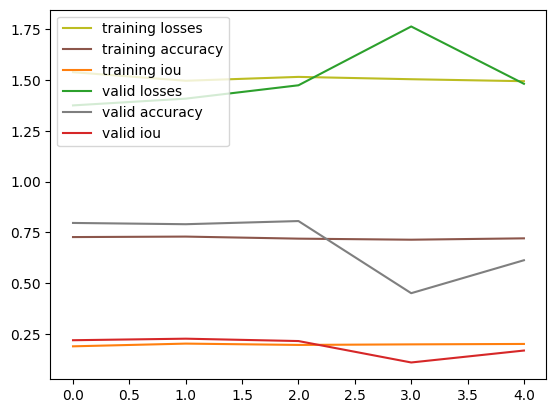

None

max valid iou: 0.22707015903372513


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
import os
from IPython.display import display
import matplotlib.pyplot as plt

max_valid_iou = 0
start = 0

running_loss = 0
running_iou = 0
running_count = 0
running_accuracy = 0
running_mae = 0

epochs = []
training_losses = []
training_accuracies = []
training_ious = []
training_mae = []
valid_losses = []
valid_accuracies = []
valid_ious = []
valid_mae = []

for i in range(start, 333):
  train_validation_loop_multilabel(net, optimizer, scheduler, train_loader, valid_loader, 3, i)
  epochs.append(i)
  x = epochs


  #   # Ensure data for plotting is on CPU and in numpy format
  training_losses_np = [loss for loss in training_losses]  # are not tensors
  valid_losses_np = [loss.item() for loss in valid_losses] # because we save all losses --> but print only the total loss (equally weighted)

  training_accuracies_np = [acc for acc in training_accuracies]  # are not tensors
  training_ious_np = [iou for iou in training_ious] # item because ious are saved as tensors
  valid_accuracies_np = [acc for acc in valid_accuracies]
  valid_ious_np = [iou for iou in valid_ious]

  plt.plot(x, training_losses_np, 'tab:olive', label='training losses')
  plt.plot(x, training_accuracies_np, 'tab:brown', label='training accuracy')
  plt.plot(x, training_ious_np, 'tab:orange', label='training iou')
  plt.plot(x, valid_losses_np, 'tab:green',label='valid losses')
  plt.plot(x, valid_accuracies_np, 'tab:grey', label='valid accuracy')
  plt.plot(x, valid_ious_np, 'tab:red', label='valid iou')

  plt.legend(loc="upper left")
  plt.show()

  display(plt.show())
  print("max valid iou:", max_valid_iou)

  if i % 10 == 0 and i != 0:
    save_base_path = '/content/drive/MyDrive/Uni/TUB/Semester/5 - Masterarbeit/models/pretext/'
    #save_path = os.path.join("checkpoints", "{}_{}_{}.cp".format(RUNNAME, i, iou.item()))
    save_path = save_base_path + '{}_{}_{}.cp'.format(RUNNAME, i, max_valid_iou)
    torch.save(net.state_dict(), save_path)



In [ ]:
# save the model at the end as well
save_base_path = '/content/drive/MyDrive/Uni/TUB/Semester/5 - Masterarbeit/models/pretext/'
save_path = save_base_path + '{}_{}_{}.cp'.format(RUNNAME, LR, 'last_iteration')
torch.save(net.state_dict(), save_path)

## 6. Look at outputs

In [ ]:
import matplotlib.pyplot as plt
import torch
from torchvision.transforms.functional import to_pil_image
from tqdm.notebook import tqdm

# this only makes sense if the label is LC
def visualize_segmentation_example_multilabel(net, test_data_loader, cmap):
    net.eval()  # Ensure the model is in evaluation mode.
    net.cuda()  # Ensure the model operates on the GPU.

    with torch.no_grad():  # Disable gradient computation for efficiency.
        # Iterating over the test dataset to get a single batch.
        for images, labels in tqdm(test_data_loader):

            images = images.cuda()
            outputs = net(images) # [6, 25, 256, 256]


            label = labels[:, 0, :, :] # dimension as [batch_size, height, width], i.e. removed the single dimension as cross entropy expects [batch size, height, width]
            label = label.cuda()
            # Assuming the outputs of the classification task are raw logits, apply softmax to obtain probabilities.
            probs_lc = torch.softmax(outputs, dim=1)
            # Convert probabilities to predicted class labels.
            predicted_masks_lc = torch.argmax(probs_lc, dim=1)
            # move it to CPU for vis
            predicted_masks_lc = predicted_masks_lc.cpu()

            # Move the tensors to the CPU for visualization.
            images, label = images.cpu(), label.cpu()


            true_mask = to_pil_image(label[0].float()) #.float() # Adding channel dimension for compatibility. # this could be an error, maybe leave the unsqueeze part away
            predicted_mask = to_pil_image(predicted_masks_lc[0].unsqueeze(0).byte())


            # Visualization
            fig, ax = plt.subplots(2, 2, figsize=(20, 10))

            ax[0,0].imshow(images[0][0], cmap=cmap_sar, vmin=-4, vmax=4)
            ax[0,0].set_title('Original Image Band 1')
            ax[0,0].axis('off')

            ax[1,0].imshow(images[0][1], cmap=cmap_sar, vmin=-4, vmax=4) # second row, first column
            ax[1,0].set_title('Original Image Band 2')
            ax[1,0].axis('off')

            img_1 = ax[0,1].imshow(label[0], cmap=cmap_pop, vmin=0, vmax=5)
            ax[0,1].set_title(f'True Mask {AUXILIARY_DATASOURCE}')
            ax[0,1].axis('off')

            img_2 = ax[1,1].imshow(predicted_mask, cmap=cmap_pop, vmin=0, vmax=5)
            ax[1,1].set_title(f'Predicted Mask {AUXILIARY_DATASOURCE}')
            ax[1,1].axis('off')

            plt.colorbar(img_1, ticks=range(6))
            plt.colorbar(img_2, ticks=range(6))

            plt.show()

            # Break after the first batch to only visualize one example.



In [ ]:
# load a net and look at visualisations
model = smp.Unet(encoder_name='resnet18', encoder_weights=None, in_channels=2, classes = 6)
model = convertBNtoGN(model)
model_save_path = '/content/drive/MyDrive/Uni/TUB/Semester/5 - Masterarbeit/models/pretext/'
checkpoints = os.listdir(model_save_path)
state_dict = torch.load(model_save_path + 'pretext_BUILT_allData_test1_0.001BUILT_100_0.2735105198594408.cp')
model.load_state_dict(state_dict)

<All keys matched successfully>

  0%|          | 0/19 [00:00<?, ?it/s]

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 3, 3, 3],
        [0, 0, 0,  ..., 3, 3, 3],
        [0, 0, 0,  ..., 3, 3, 3]], dtype=torch.uint8)
tensor([[0, 0, 0,  ..., 2, 0, 0],
        [0, 1, 1,  ..., 2, 2, 0],
        [1, 1, 1,  ..., 2, 2, 2],
        ...,
        [0, 0, 0,  ..., 3, 3, 3],
        [2, 2, 0,  ..., 3, 3, 3],
        [2, 2, 0,  ..., 3, 4, 4]])


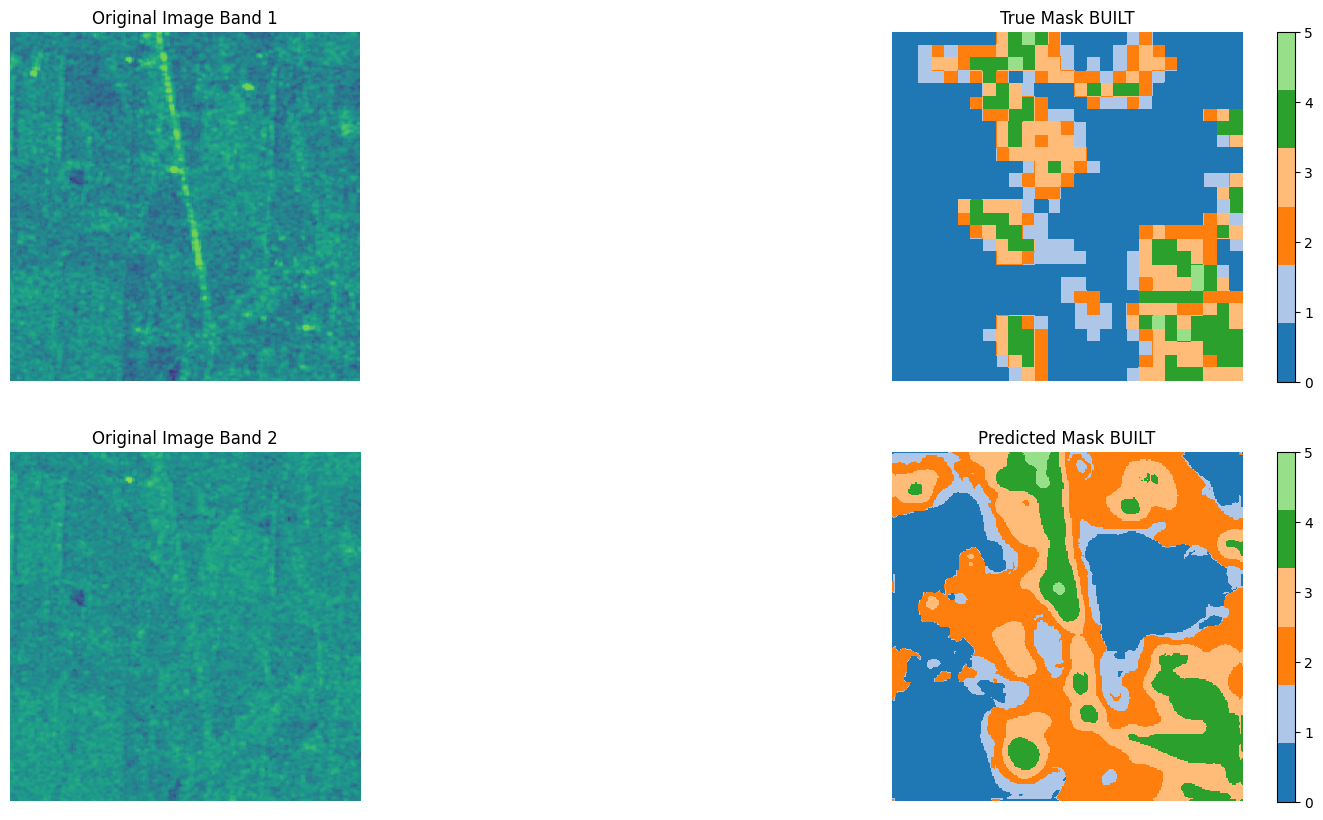

tensor([[3, 3, 3,  ..., 3, 3, 3],
        [3, 3, 3,  ..., 3, 3, 3],
        [3, 3, 3,  ..., 3, 3, 3],
        ...,
        [3, 3, 3,  ..., 3, 3, 3],
        [3, 3, 3,  ..., 3, 3, 3],
        [3, 3, 3,  ..., 3, 3, 3]], dtype=torch.uint8)
tensor([[3, 3, 2,  ..., 3, 3, 2],
        [3, 2, 2,  ..., 3, 3, 3],
        [3, 3, 2,  ..., 2, 3, 3],
        ...,
        [3, 3, 3,  ..., 3, 3, 3],
        [3, 3, 3,  ..., 3, 3, 3],
        [3, 4, 4,  ..., 3, 3, 4]])


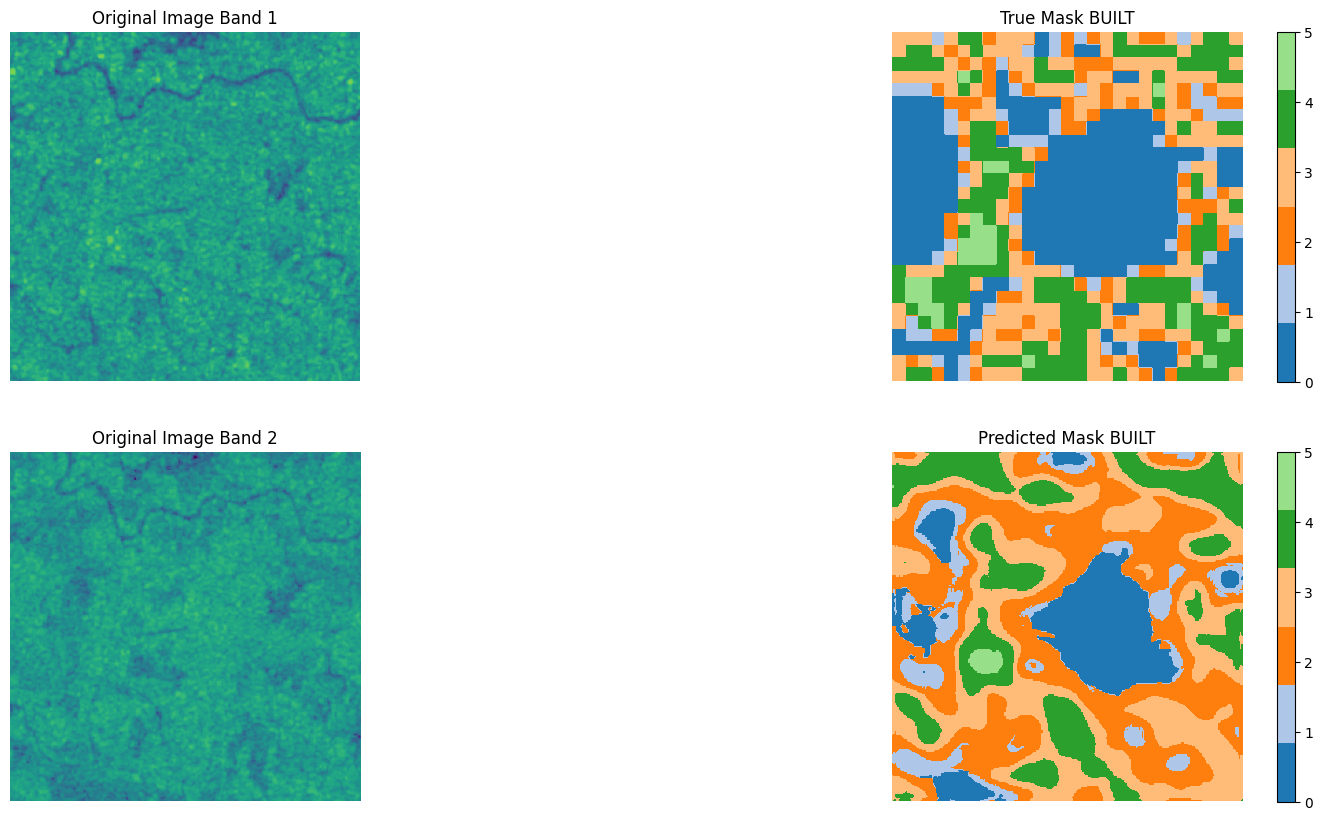

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.uint8)
tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])


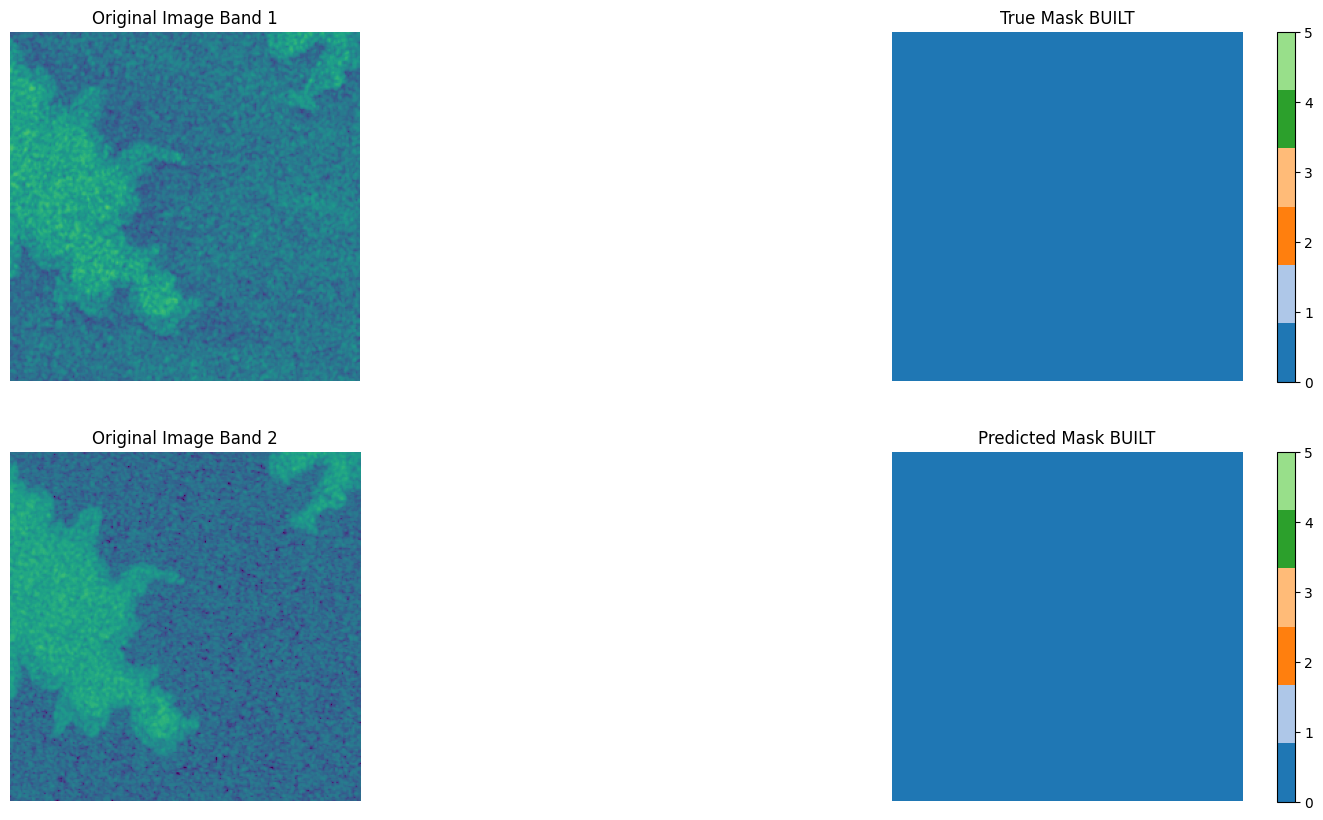

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.uint8)
tensor([[0, 0, 0,  ..., 4, 4, 4],
        [0, 0, 0,  ..., 4, 4, 4],
        [0, 0, 0,  ..., 4, 4, 4],
        ...,
        [0, 0, 0,  ..., 2, 2, 2],
        [0, 0, 0,  ..., 2, 2, 2],
        [0, 0, 0,  ..., 2, 2, 2]])


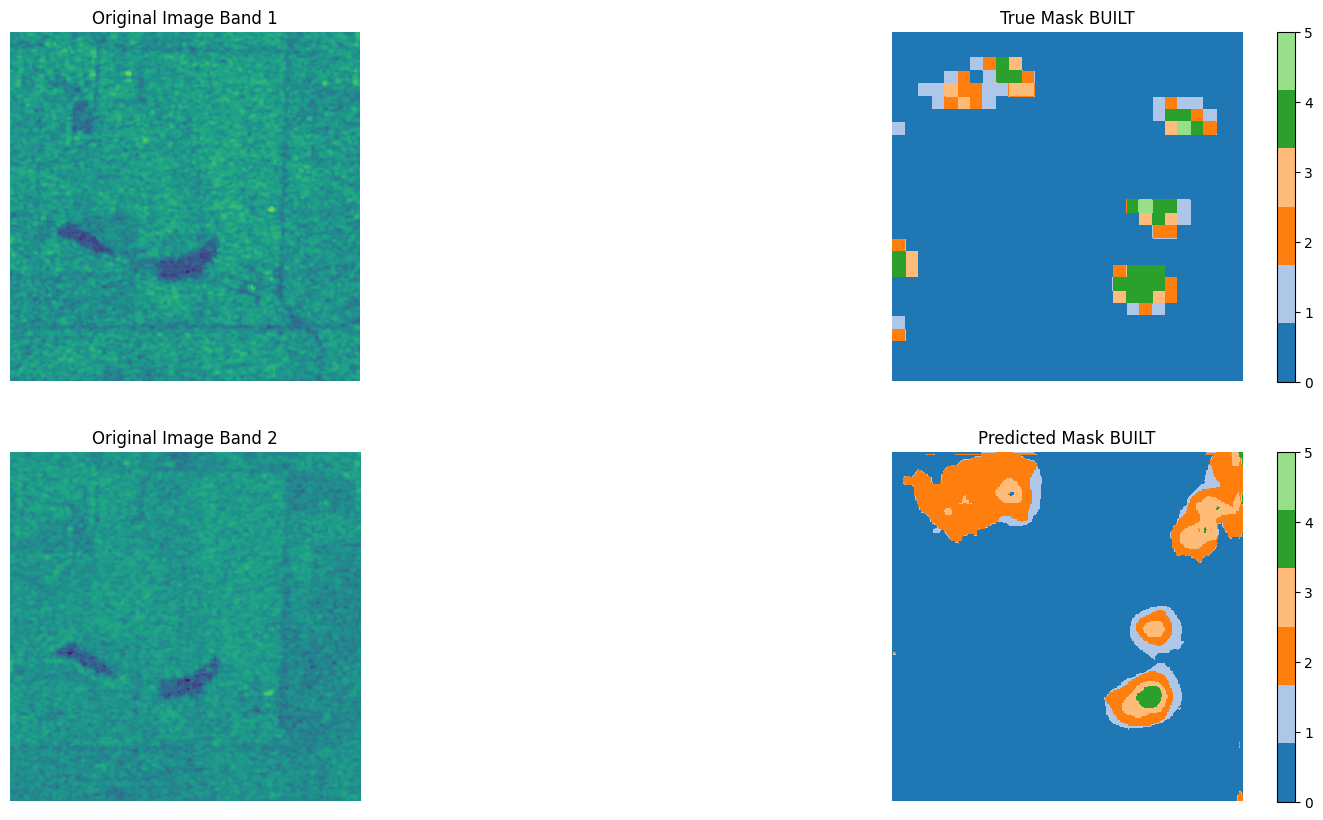

tensor([[2, 2, 2,  ..., 0, 0, 0],
        [2, 2, 2,  ..., 0, 0, 0],
        [2, 2, 2,  ..., 0, 0, 0],
        ...,
        [5, 5, 5,  ..., 0, 0, 0],
        [5, 5, 5,  ..., 0, 0, 0],
        [5, 5, 5,  ..., 0, 0, 0]], dtype=torch.uint8)
tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [5, 5, 5,  ..., 2, 2, 2],
        [4, 5, 5,  ..., 2, 2, 2],
        [4, 4, 5,  ..., 2, 2, 2]])


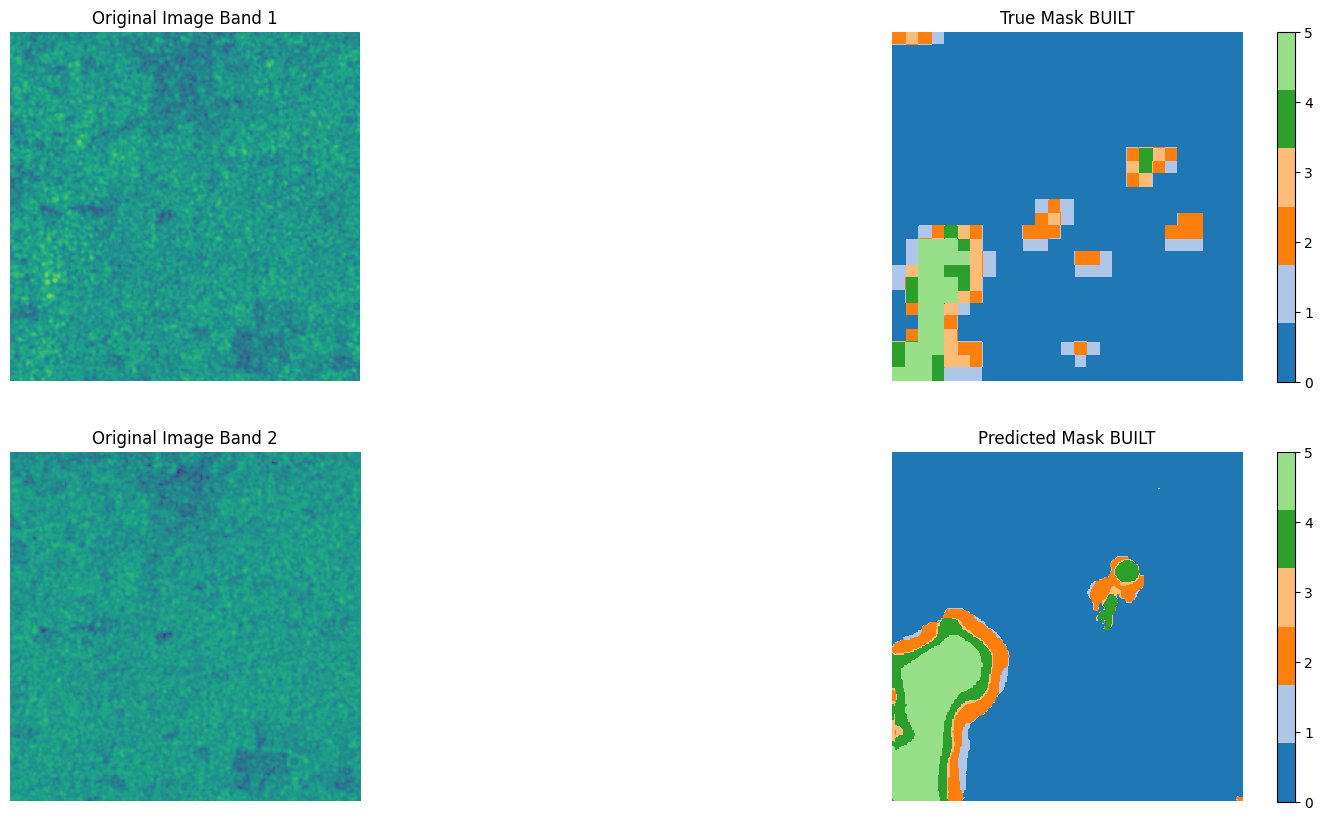

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.uint8)
tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 2, 2, 0],
        [0, 0, 0,  ..., 2, 2, 3],
        ...,
        [0, 0, 0,  ..., 2, 2, 0],
        [0, 0, 0,  ..., 2, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])


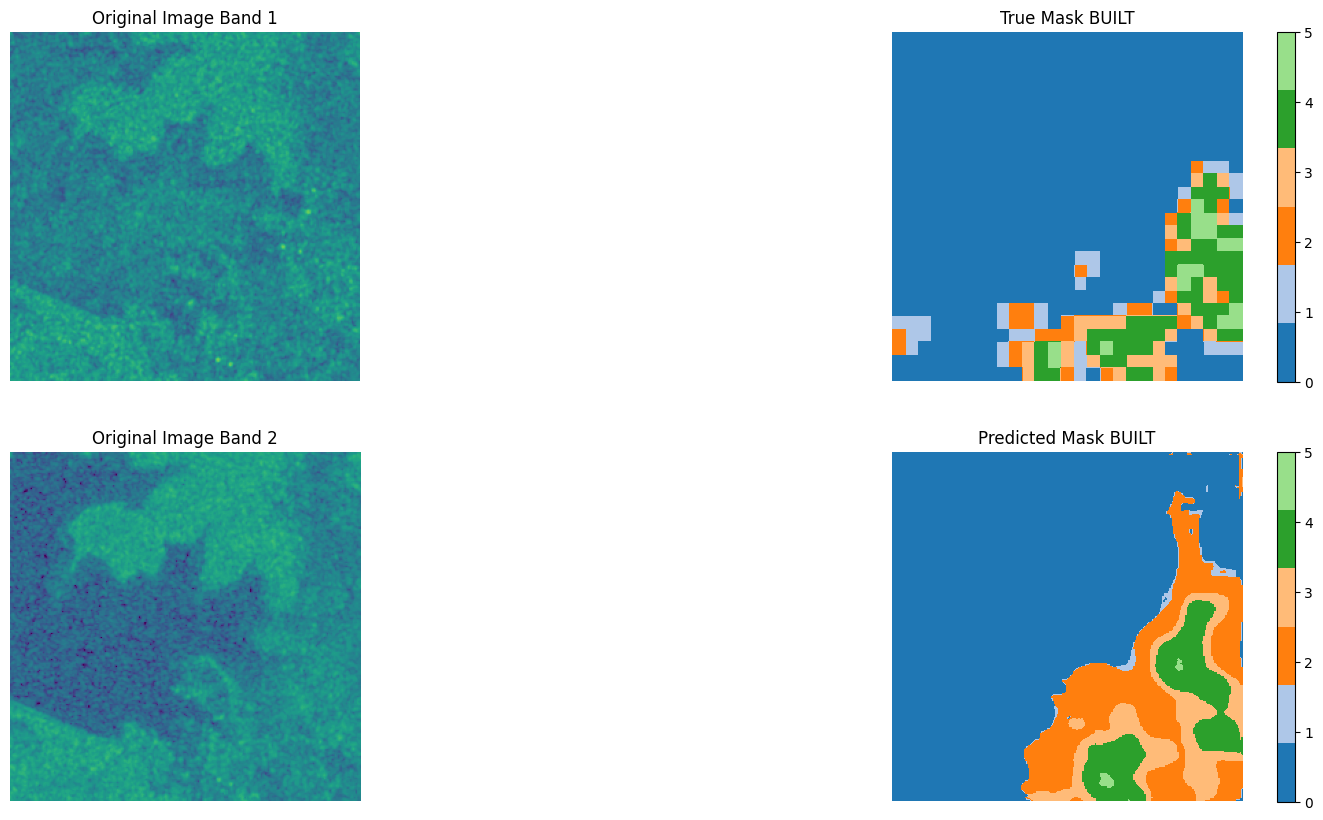

tensor([[0, 0, 0,  ..., 3, 3, 3],
        [0, 0, 0,  ..., 3, 3, 3],
        [0, 0, 0,  ..., 3, 3, 3],
        ...,
        [3, 3, 3,  ..., 4, 4, 4],
        [3, 3, 3,  ..., 4, 4, 4],
        [3, 3, 3,  ..., 4, 4, 4]], dtype=torch.uint8)
tensor([[4, 3, 3,  ..., 3, 3, 4],
        [3, 3, 3,  ..., 3, 3, 3],
        [3, 3, 3,  ..., 3, 3, 3],
        ...,
        [3, 3, 2,  ..., 3, 3, 4],
        [3, 3, 2,  ..., 3, 3, 4],
        [2, 3, 3,  ..., 4, 4, 4]])


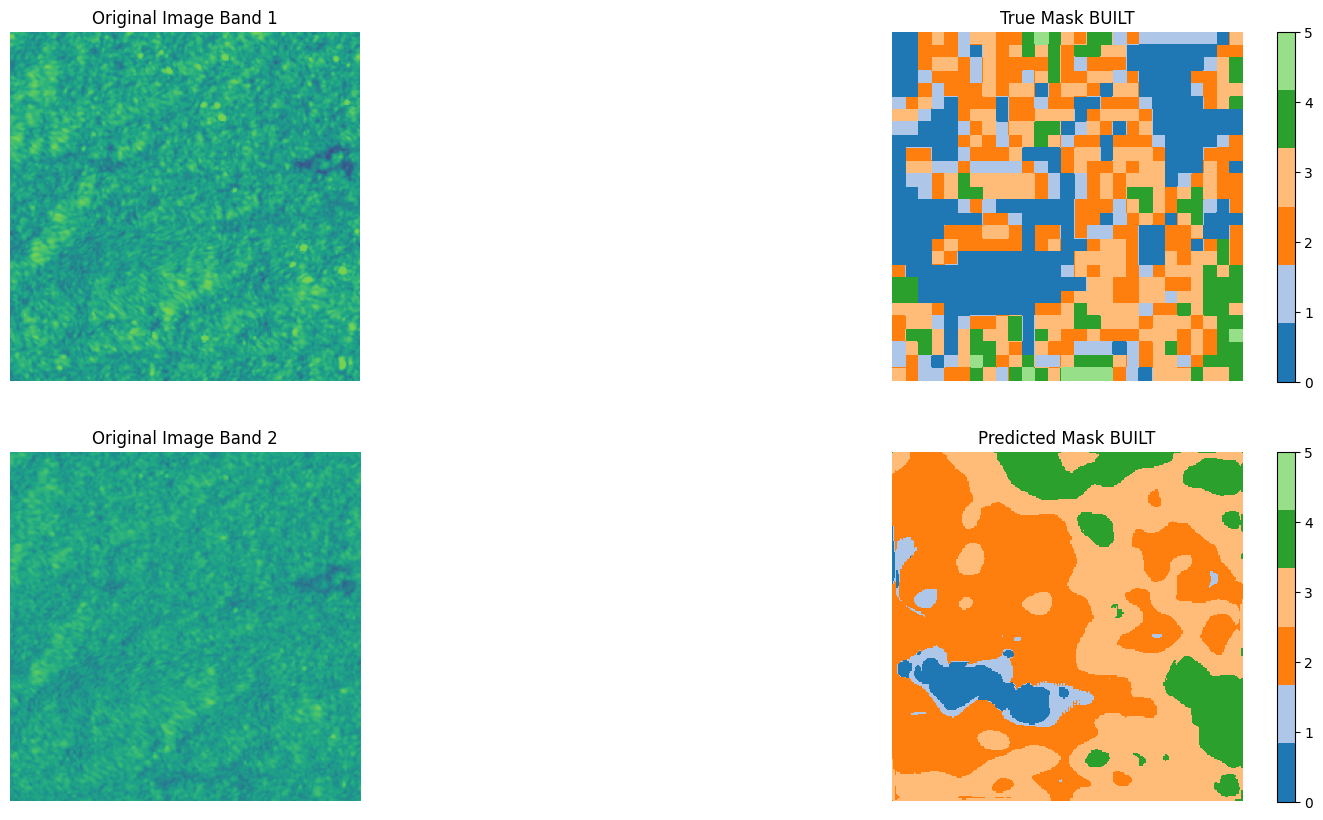

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.uint8)
tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])


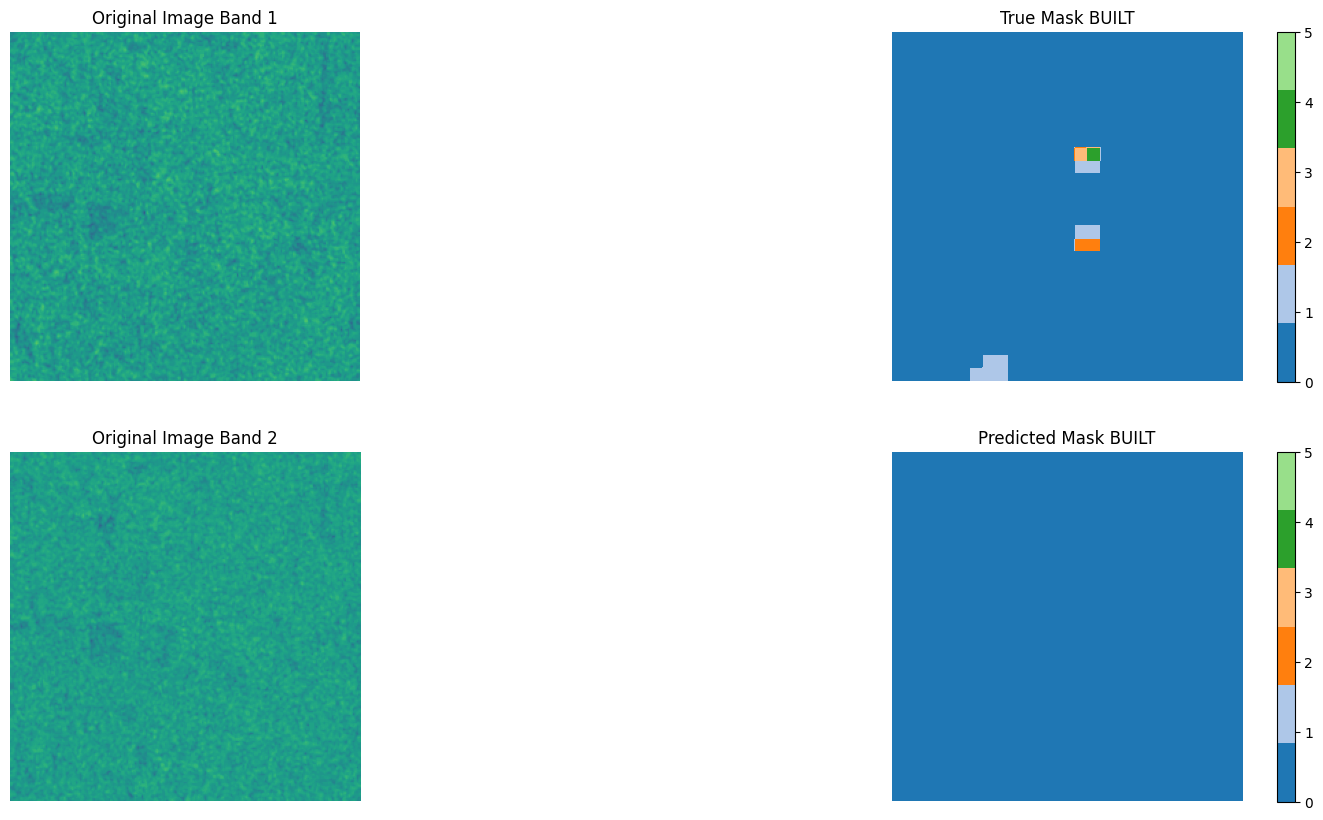

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.uint8)
tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])


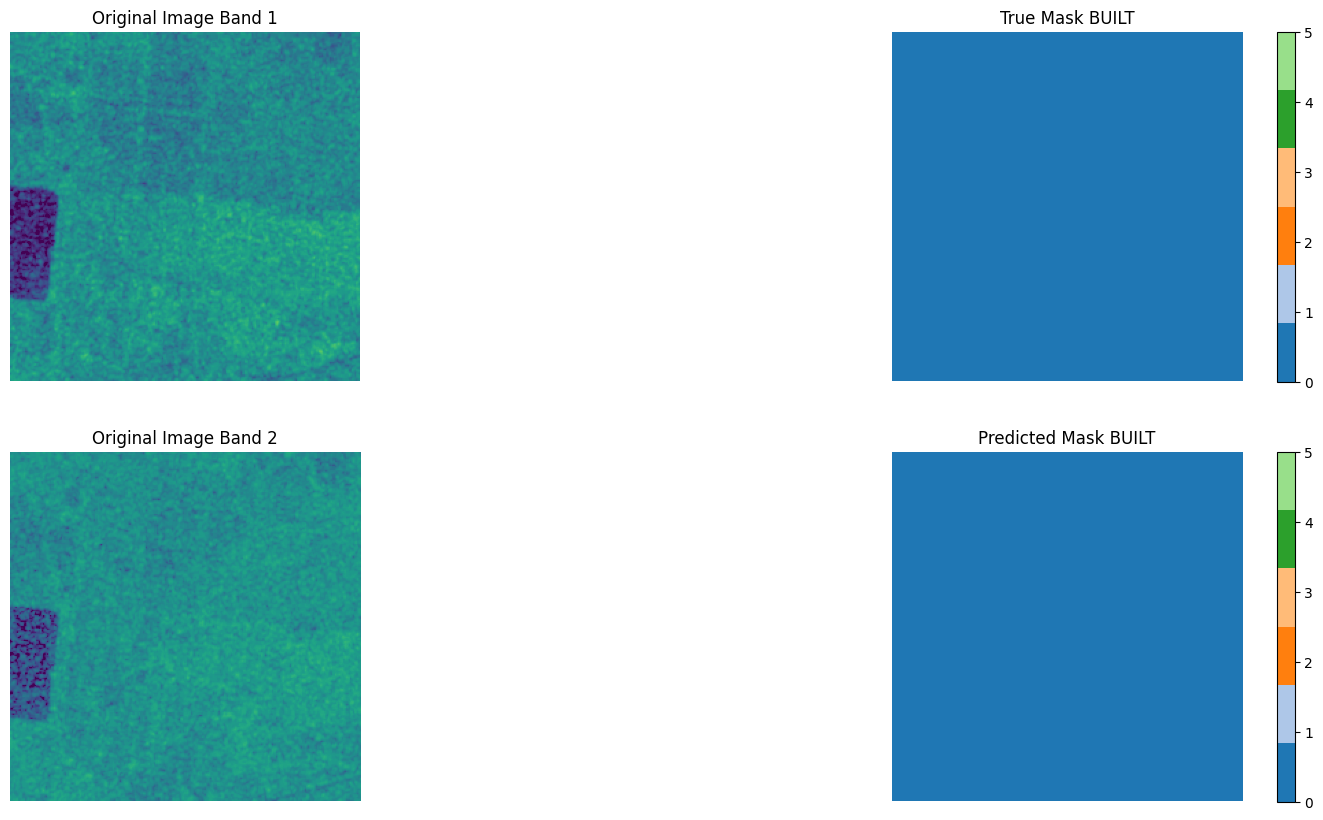

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.uint8)
tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])


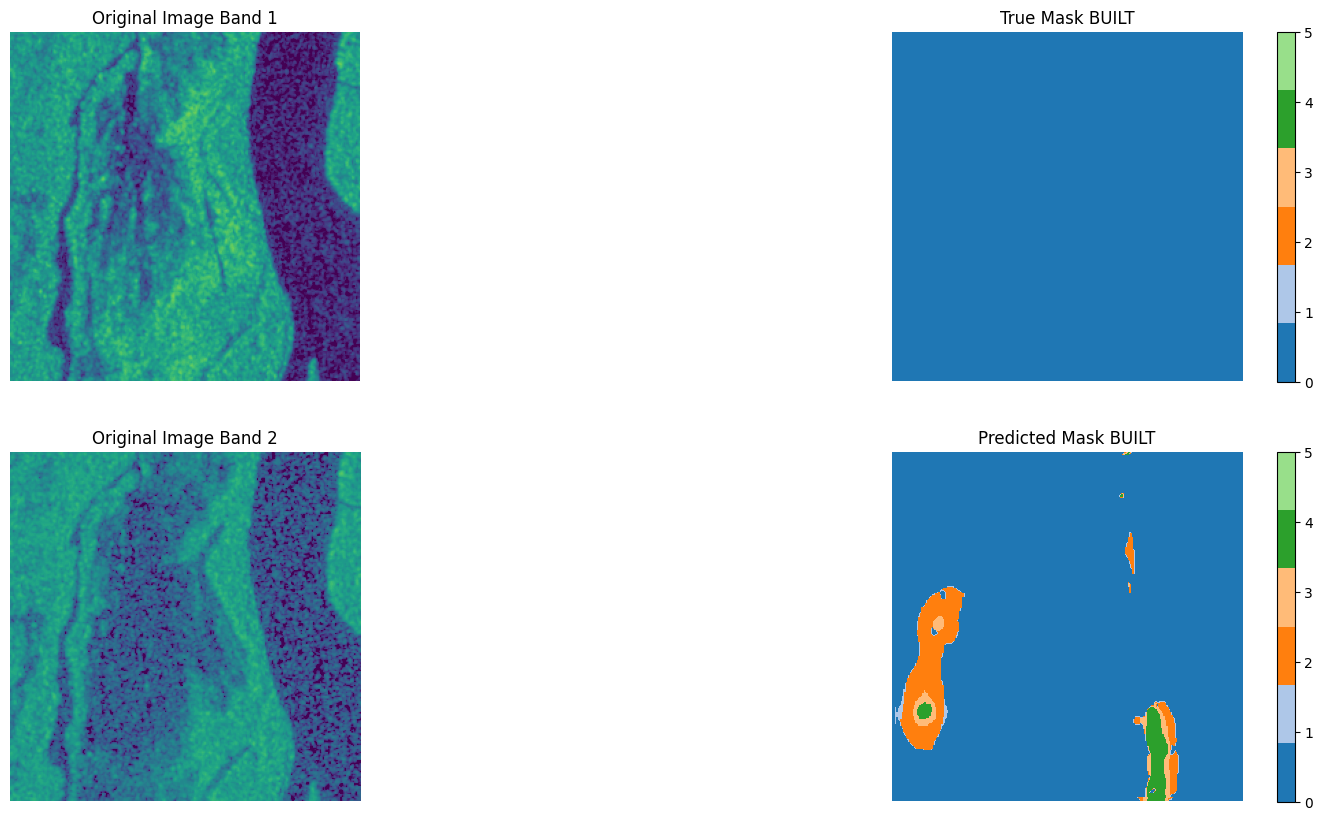

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [4, 4, 4,  ..., 5, 5, 5],
        [4, 4, 4,  ..., 5, 5, 5],
        [4, 4, 4,  ..., 5, 5, 5]], dtype=torch.uint8)
tensor([[4, 2, 2,  ..., 2, 2, 2],
        [4, 2, 2,  ..., 2, 2, 2],
        [4, 2, 2,  ..., 2, 2, 2],
        ...,
        [4, 4, 4,  ..., 5, 5, 5],
        [4, 4, 4,  ..., 5, 5, 5],
        [4, 4, 4,  ..., 5, 5, 5]])


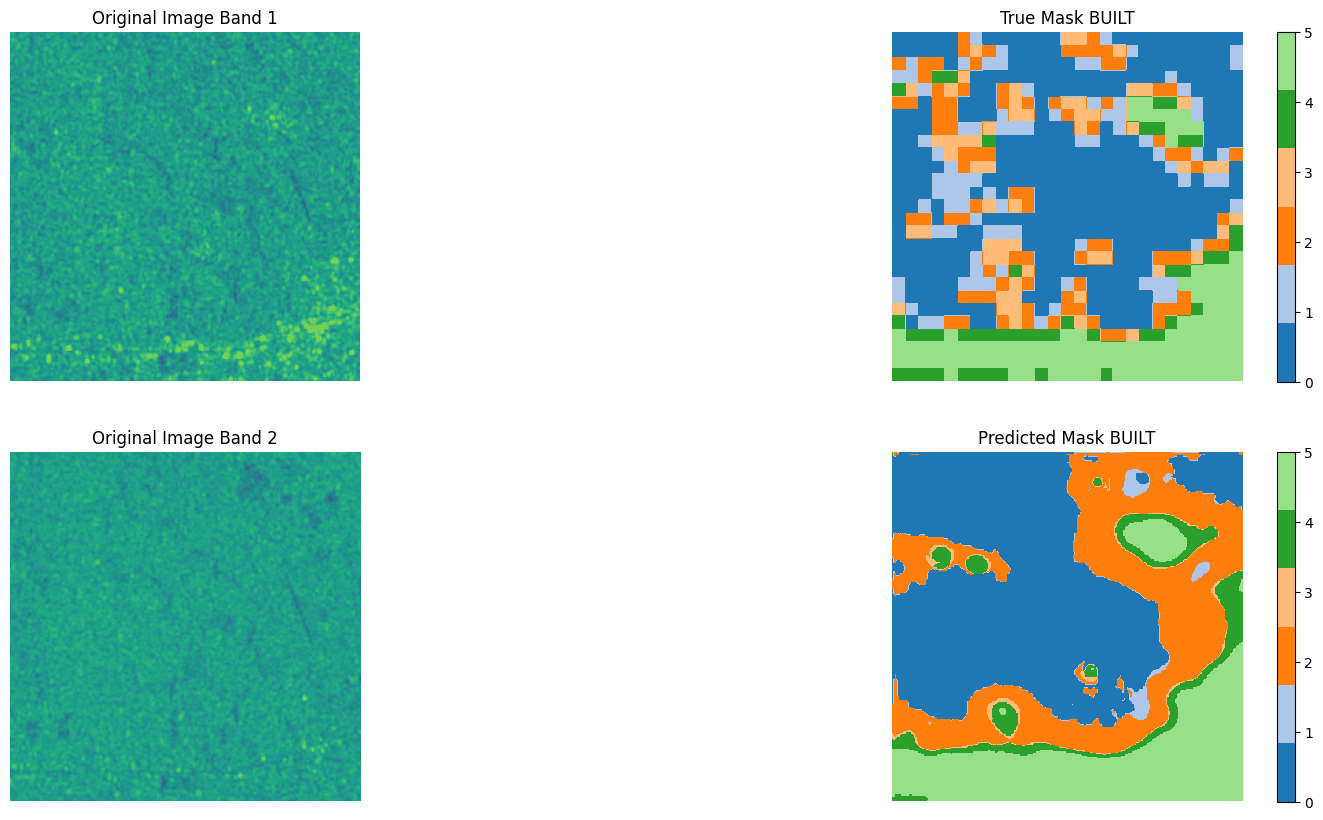

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [2, 2, 2,  ..., 1, 1, 1],
        [2, 2, 2,  ..., 1, 1, 1],
        [2, 2, 2,  ..., 1, 1, 1]], dtype=torch.uint8)
tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])


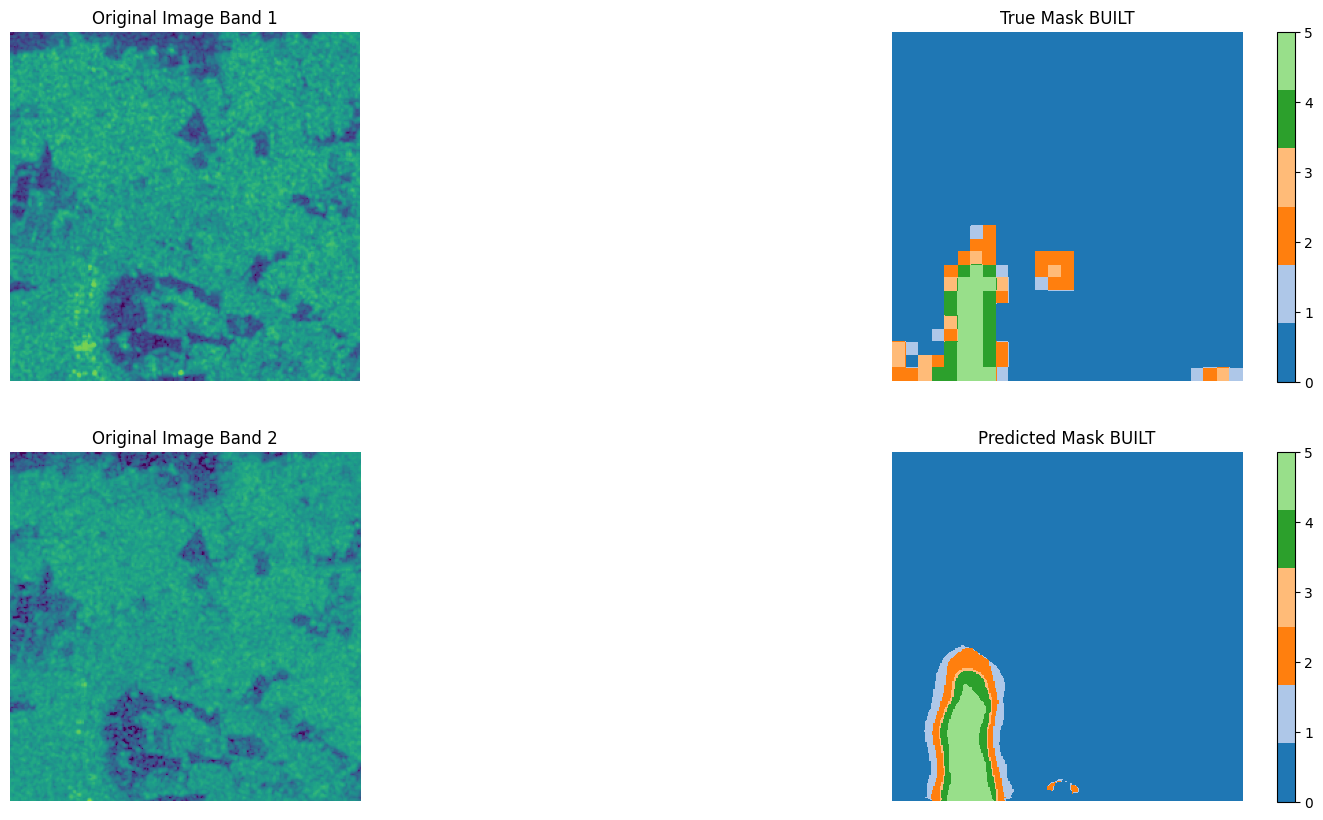

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.uint8)
tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])


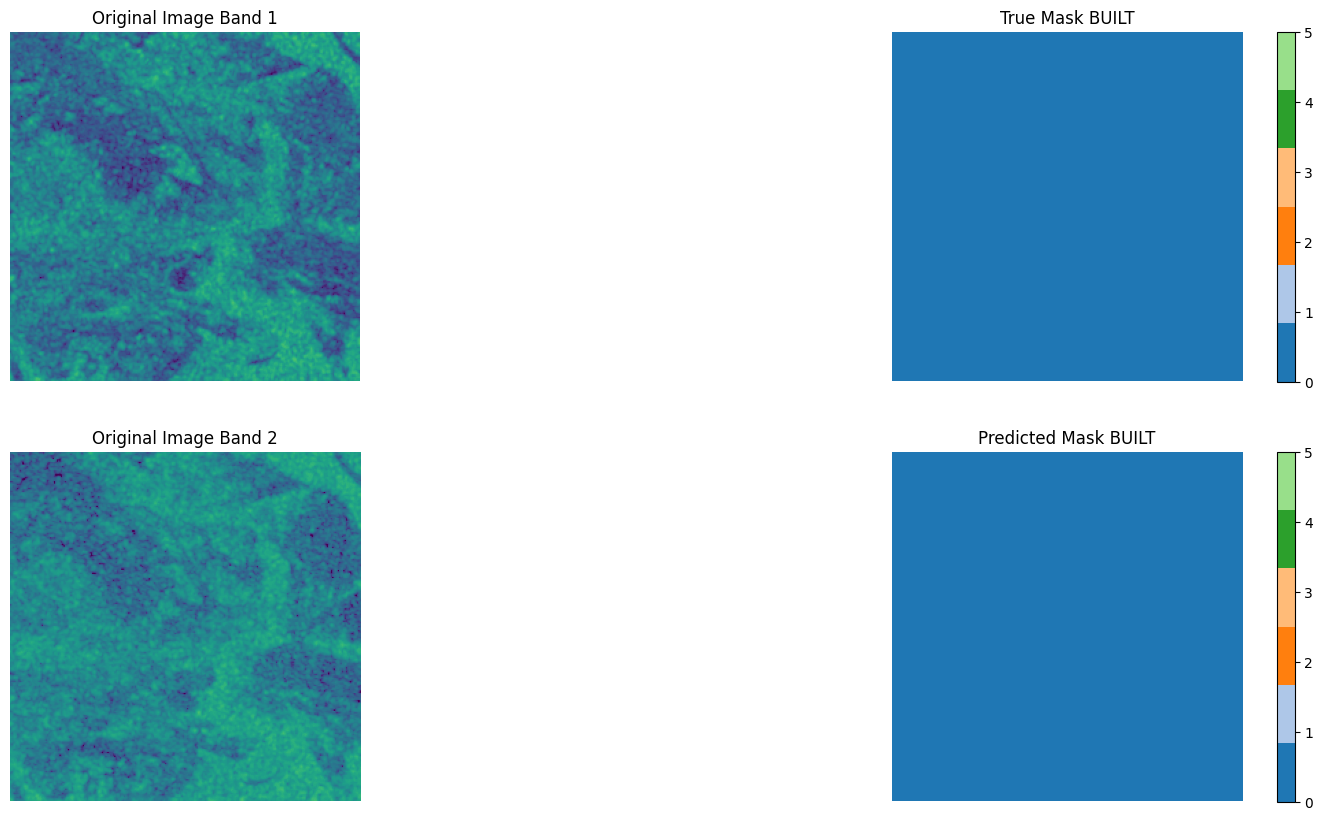

tensor([[3, 3, 3,  ..., 5, 5, 5],
        [3, 3, 3,  ..., 5, 5, 5],
        [3, 3, 3,  ..., 5, 5, 5],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.uint8)
tensor([[5, 5, 5,  ..., 5, 5, 5],
        [5, 5, 5,  ..., 5, 5, 5],
        [5, 5, 5,  ..., 5, 5, 5],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 2, 4],
        [0, 0, 0,  ..., 0, 4, 4]])


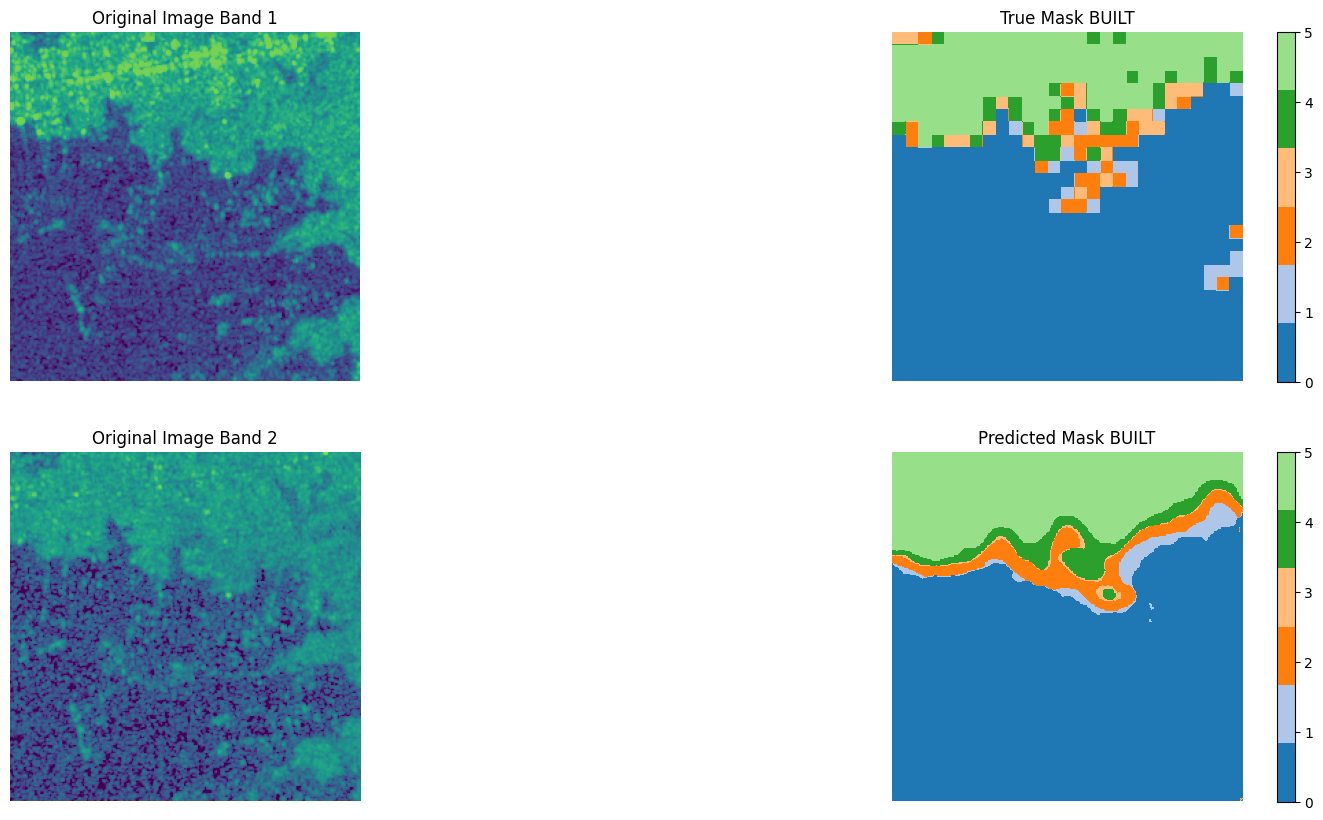

tensor([[4, 4, 4,  ..., 5, 5, 5],
        [4, 4, 4,  ..., 5, 5, 5],
        [4, 4, 4,  ..., 5, 5, 5],
        ...,
        [0, 0, 0,  ..., 5, 5, 5],
        [0, 0, 0,  ..., 5, 5, 5],
        [0, 0, 0,  ..., 5, 5, 5]], dtype=torch.uint8)
tensor([[5, 5, 5,  ..., 4, 4, 5],
        [5, 5, 5,  ..., 4, 4, 4],
        [5, 5, 5,  ..., 4, 4, 4],
        ...,
        [2, 2, 2,  ..., 5, 5, 5],
        [4, 2, 2,  ..., 5, 5, 5],
        [4, 2, 2,  ..., 5, 5, 5]])


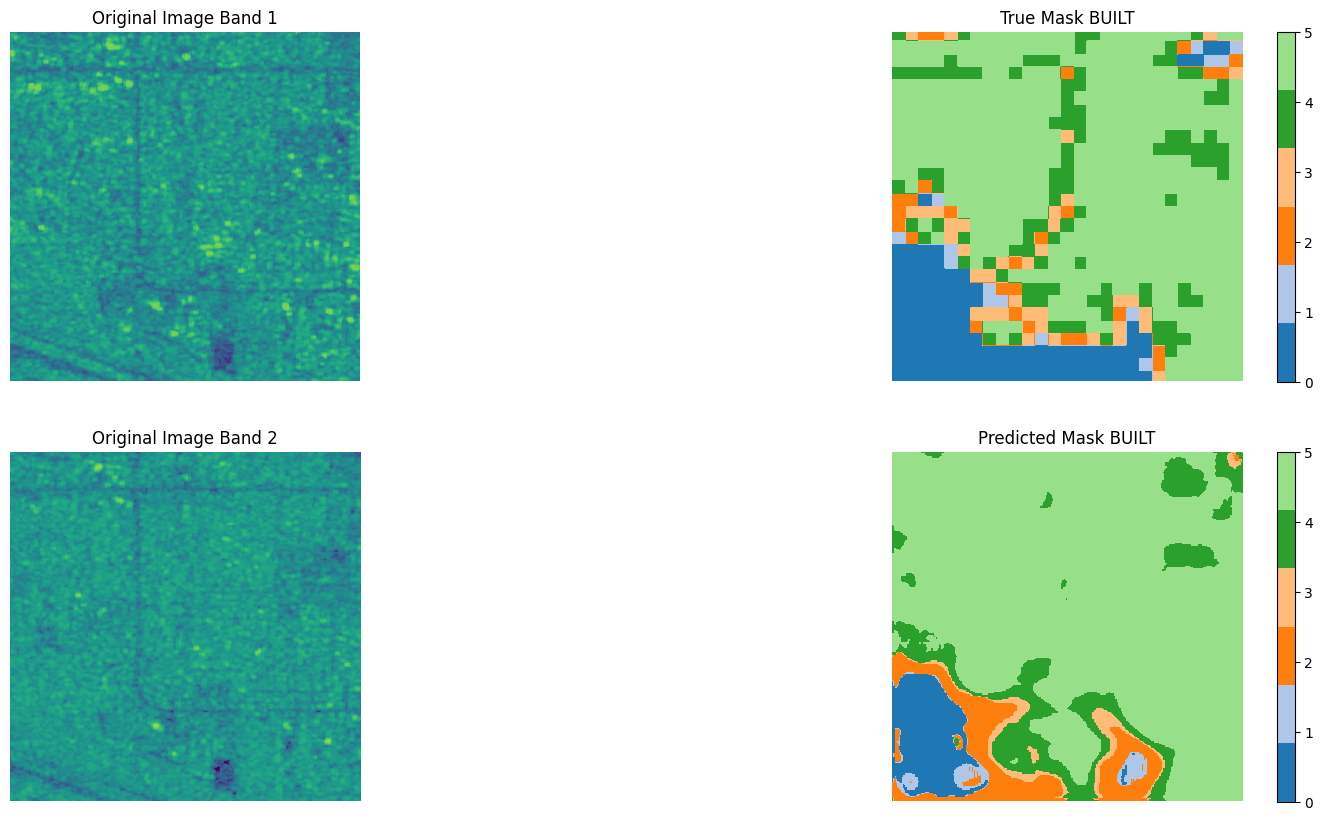

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.uint8)
tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])


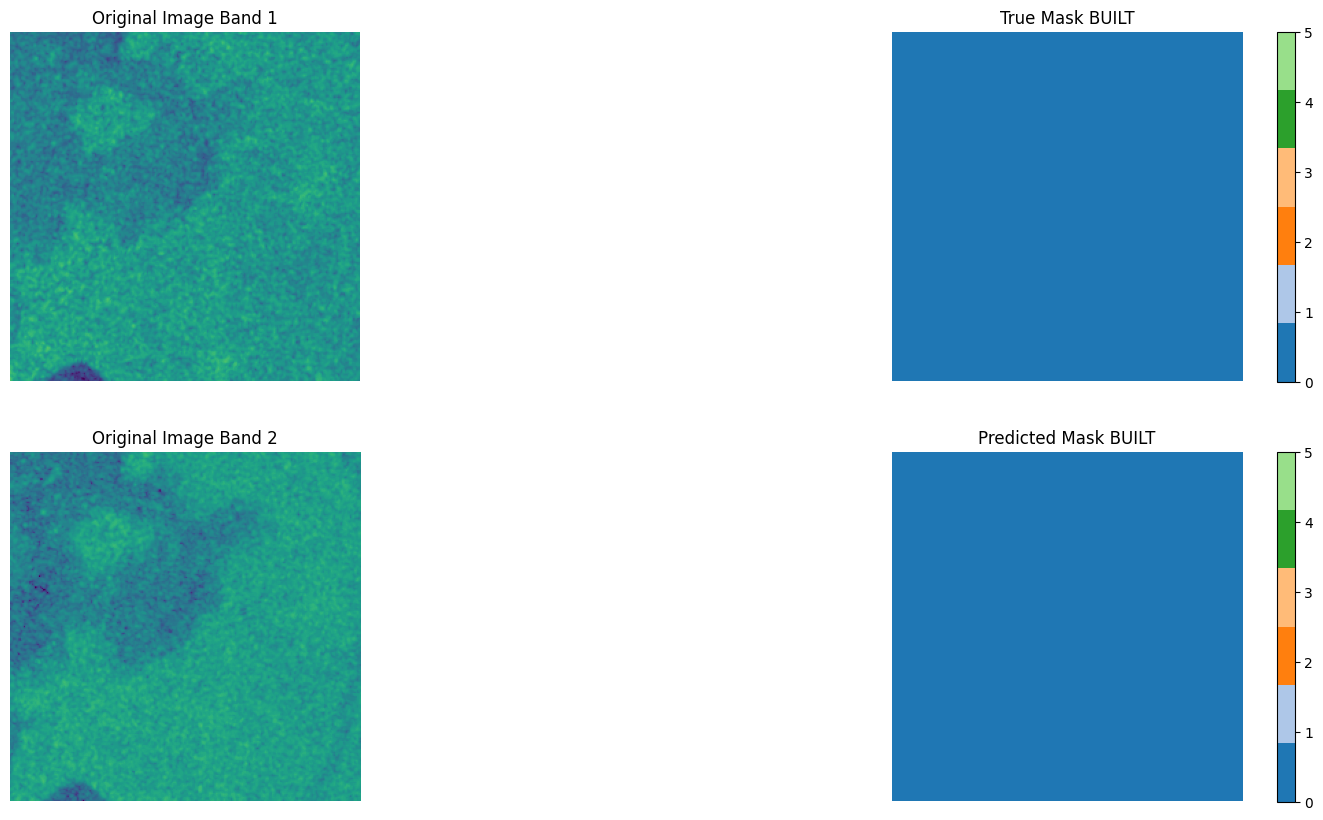

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.uint8)
tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])


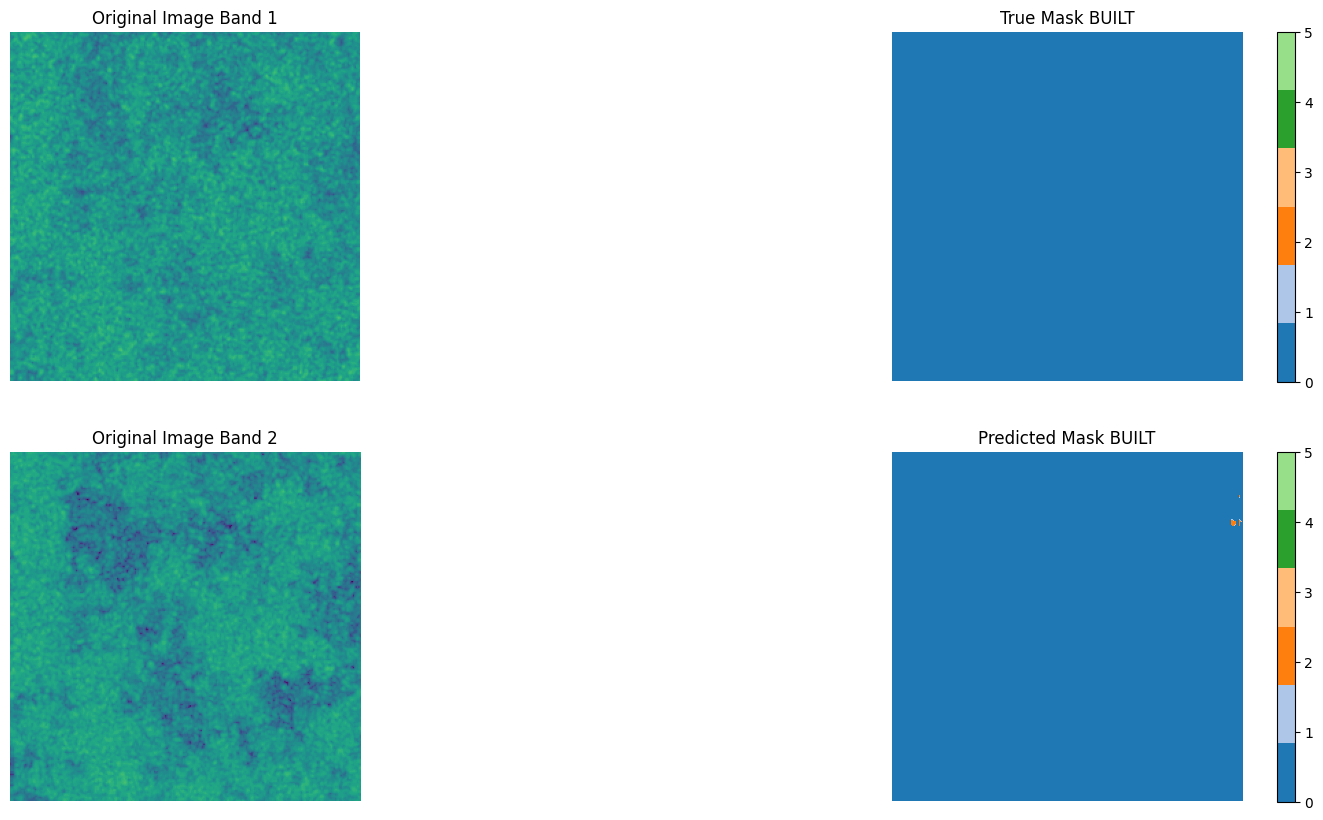

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.uint8)
tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])


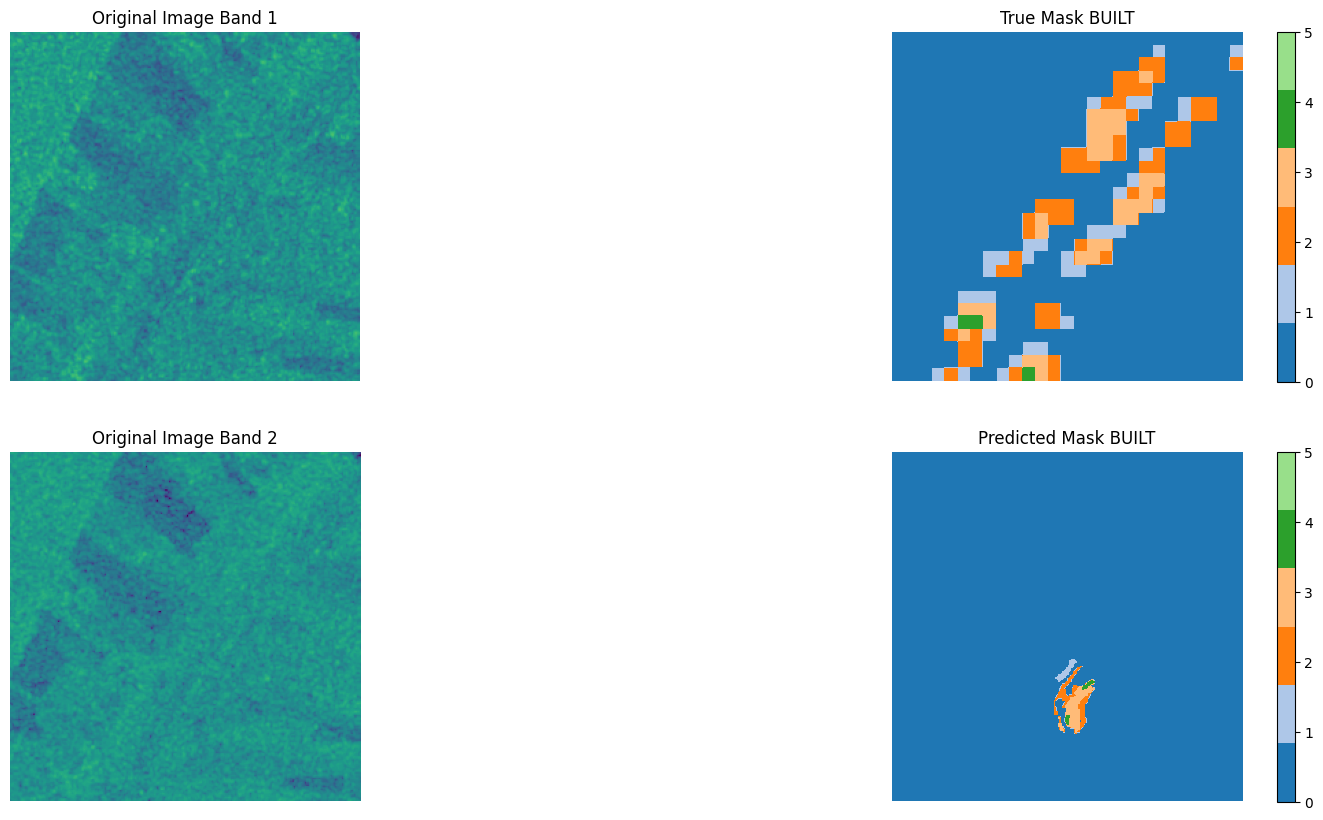

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.uint8)
tensor([[0, 0, 0,  ..., 2, 2, 2],
        [0, 0, 0,  ..., 2, 2, 2],
        [0, 0, 0,  ..., 2, 2, 2],
        ...,
        [0, 0, 0,  ..., 2, 2, 2],
        [0, 0, 0,  ..., 2, 2, 2],
        [0, 0, 0,  ..., 2, 2, 0]])


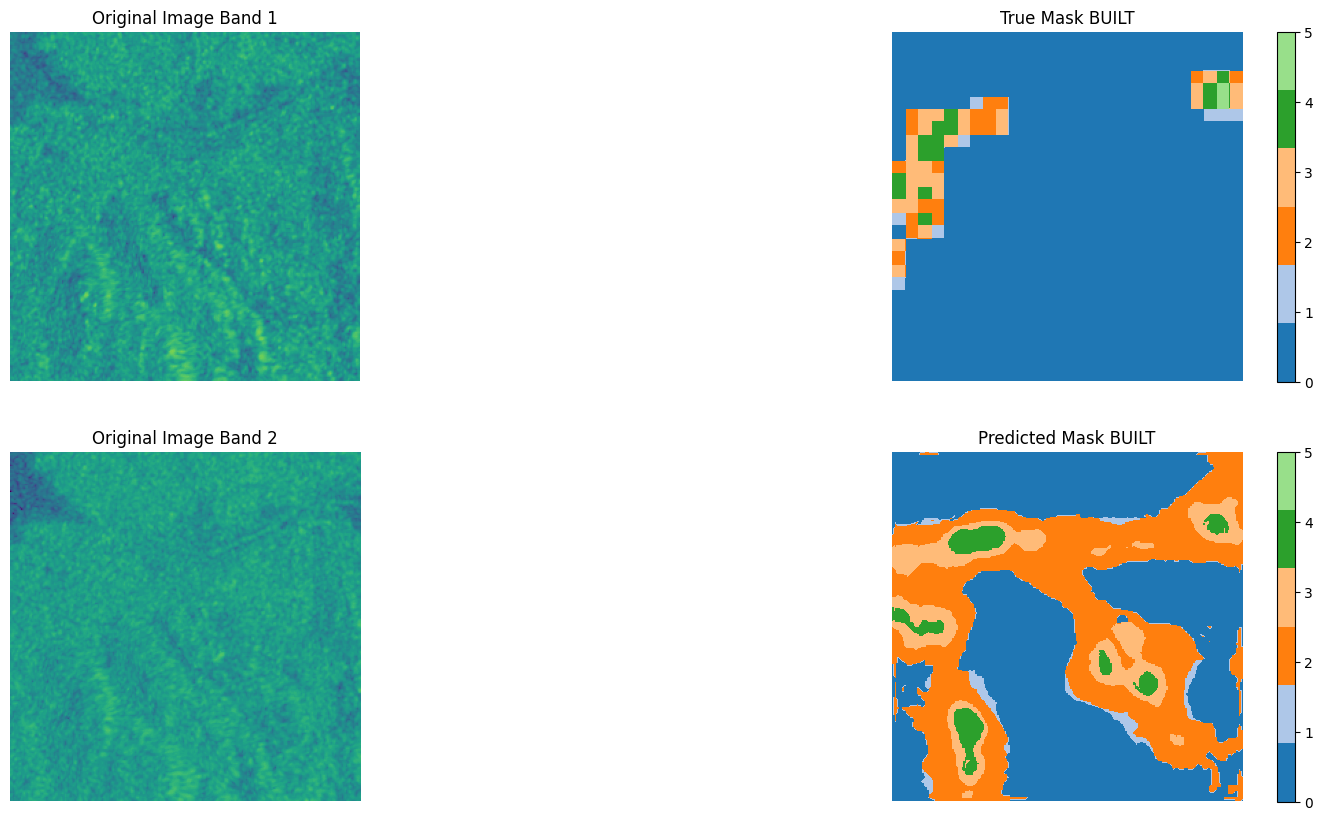

In [ ]:
visualize_segmentation_example_multilabel(model, valid_loader, cmap_pop)